## Homework 2

Dragana Saric, Milena Djurdjic, Paul Kneringer, Petar Petrov

### Exercise 1
Implement AdaGrad and use it to fit the linear advertising sales model. Wrap AdaGrad into a separate function that requires X and y as input arguments (optional: iterations, default = 10n) and returns the parameter vector b. This function should be used from now on two fit models. What do you observe when comparing it to stochastic gradient descent or the analytic solution using scikit-learn?

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import random, math
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import KFold
%matplotlib inline

In [2]:
df = pd.read_csv('http://www-bcf.usc.edu/~gareth/ISL/Advertising.csv', index_col=0)
df.head()

,TV,radio,newspaper,sales
1,230.1,37.8,69.2,22.1
2,44.5,39.3,45.1,10.4
3,17.2,45.9,69.3,9.3
4,151.5,41.3,58.5,18.5
5,180.8,10.8,58.4,12.9


In [8]:
#create different arrays for sales and adv. types
y = df.sales.values
X = df.drop(["sales"], axis=1).values
#add a column of 1s to X for the b0
X = np.c_[np.ones(X.shape[0]),X]

In [136]:
#define ada_grad function
def ada(X=0, y=0, m=10):
    b = np.zeros(X.shape[1])
    # Init sum of squared gradients 
    g = 0
    
    # Number of rows in df
    n = X.shape[0]
    
    for k in range(m*n):
        # Randomly select one row
        i = np.random.randint(0, n)
        
        # Calculate gradient
        grad = -(b.dot(X[i]) - y[i])*X[i]
        
        # Sum of previous gradients
        g = g + (grad)**2        
      
        # Calculate new paramter
        b = np.add(b,( 1/np.sqrt(g)) * grad)
        
    return b


In [138]:
b = ada(X=X, y=y)
b

array([ 2.04759737,  0.05341404,  0.21466297,  0.03741679])

In [139]:
n = len(df)
rss =  sum((y[i]-b.dot(X[i]))**2 for i in range(n))
tss = sum((y[i]-y.mean())**2 for i in range(n))
r_squared = 1.-rss/tss
mse = rss/n
mse, r_squared, b

(8.4454884287459535,
 0.68819433179692702,
 array([ 2.04759737,  0.05341404,  0.21466297,  0.03741679]))

### Exercise 2
Run your algorithm to make the following prediction $$Sales = b_0 + b_1 TV$$ and plot the prediction against the original data using Matplotlib.

In [140]:
#Insert ones in the first col
X_TV = df.drop(['sales', 'newspaper', 'radio'], axis = 1).values
X_TV = np.c_[np.ones(n), X_TV]

In [142]:
#Use the function defined in example one 
ada_TV = ada(X=X_TV, y=y)
ada_TV

array([ 6.13580581,  0.06614661])

In [164]:
res = (ada_TV.dot(X_TV[i]) for i in range(n))
res = list(res)
res[0:10]

[21.356141664072553,
 9.0793301268349573,
 7.2735275677477471,
 16.157017812634649,
 18.095113599493818,
 6.7112813497169306,
 9.9392361073526772,
 14.086628798003524,
 6.7046666883283326,
 19.351899263327407]

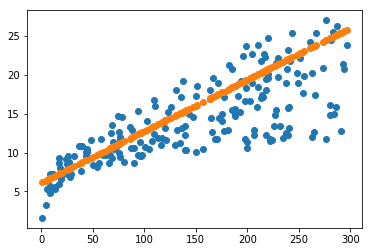

In [159]:
#Create the object and plot the observed and the predicted values 
fig, ax = plt.subplots()
ax.plot(df['TV'], y, 'o')
ax.plot(df['TV'], res, 'o')

### Exercise 3
Write an automated variable selection method that searches for the best polynomial degrees of 'TV' and 'radio' up to degree 5. You can do this by iteratively adding a polynomial as an additional column to the feature matrix $X$. Use the AIC to keep track of trade-off between number of model parameters (features) and model fit (RSS) and exit when the minimum AIC is reached.

In [160]:
#Insert ones in the first col
X_TV = df.drop(['sales', 'newspaper', 'radio'], axis = 1).values
X_TV = np.c_[np.ones(n), X_TV]


In [161]:
def selection(X,y):
    #Number of rows and columns + power used for new columns
    rows = X.shape[0]
    cols = X.shape[1]
    power = 2
    
    #Use method from example one to get param vector
    z = ada(X = X, y = y)
    
    #Define the sum of errors across all observations: rss
    rss = sum((y[i] - z.dot(X[i]))** 2 for i in range(rows))
    
    #Define AIC
    aic_1 = 2 * cols + rows * math.log(rss/rows) 
    
    while True:
        #New column is added 
        X_new = np.c_[X, np.power(X[:,1], power)]
        
        #Get amount of columns in X_new
        cols = X_new.shape[1]
        
        #Use method again on X_new
        z = ada(X = X_new, y = y)
        
         #Define the sum of errors across all observations: rss for X_new
        rss = sum((y[i] - z.dot(X_new[i]))** 2 for i in range(rows))
        
        #Define AIC for the new model
        aic_2 =  2 * cols + rows * math.log(rss / rows) 
        
        #Checks if the new AIC is lower (better) than the old 
        if aic_2 <= aic_1:
            #True, swap values and continue with while
            X = X_new
            aic_1 = aic_2
            power = power + 1
        else:
            #False, output the old and the new AIC value, break and return
            print('aic_1:  ' + str(aic_1))
            print('aic_2:  ' + str(aic_2))
            break
    return X

In [163]:
X_selection = selection(X=X_TV, y = y)

aic_1:  602.8916166690159
aic_2:  695.4410735319831


### Exercise 4
Now use cross validation to select the best order of the polynomial. Automatically stop when the minimum $MSE$ is reached. What do you observe when comparing it to the solution using the AIC?


In [172]:
def cross_val(X, y):
    # Set start power
    power = 2
    # Set start MSE
    mse_1 = 0
    mse_0 = 0
    
    # Get number of rows
    n = X.shape[0]
    # Get number of columns
    p = X.shape[1]
    
    for k, m in KFold(n_splits=5).split(X):
        # Split Data into training and test sets
        X_k, X_m = X[k], X[m]
        y_k, y_m = y[k], y[m]
        
        b = ada(X=X_m, y=y_m)
        
        rss =  sum((y_k[i]-b.dot(X_k[i]))**2 for i in range(X_k.shape[0]))
        mse_0 = rss/X.shape[0]
        
    #Here we check the models one by one if they are better than the one we have at the moment. We save the data in two
    #variables mse_1 and mse_0 and compare them.
    
    while True:
        # Add new column: TV on power of x
        X = np.c_[X, np.power(X[:, 1], power)]
        # Get number of colums
        p = X.shape[1]

        for k, m in KFold(n_splits=5).split(X):
            # Split Data into training and test sets
            X_k, X_m = X[k], X[m]
            y_k, y_m = y[k], y[m]

            b = ada(X=X_m, y=y_m)
            rss =  sum((y_k[i]-b.dot(X_k[i]))**2 for i in range(X_k.shape[0]))
            mse_1 = rss/X.shape[0]
        
        # Is the new model better then the old one?
        if mse_1 < mse_0:
            mse_0 = mse_1
        else:
            break
    
    return X

In [176]:
crosscheck = cross_val(X=X_TV, y=y)
crosscheck[0:10]

array([[  1.00000000e+00,   2.30100000e+02,   5.29460100e+04],
       [  1.00000000e+00,   4.45000000e+01,   1.98025000e+03],
       [  1.00000000e+00,   1.72000000e+01,   2.95840000e+02],
       [  1.00000000e+00,   1.51500000e+02,   2.29522500e+04],
       [  1.00000000e+00,   1.80800000e+02,   3.26886400e+04],
       [  1.00000000e+00,   8.70000000e+00,   7.56900000e+01],
       [  1.00000000e+00,   5.75000000e+01,   3.30625000e+03],
       [  1.00000000e+00,   1.20200000e+02,   1.44480400e+04],
       [  1.00000000e+00,   8.60000000e+00,   7.39600000e+01],
       [  1.00000000e+00,   1.99800000e+02,   3.99200400e+04]])

In [177]:
crosscheck.shape


(200, 3)